# Testbed keypoint localizer

In [1]:
## import necessary stuff
import pandas as pd
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os,sys
import time

import matplotlib.pylab as plt

In [2]:
# Helperfunctions to make feature definition more readable
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


### Testwise serialization

In [4]:
img = plt.imread("test.jpeg")
img.shape


(212, 238, 3)

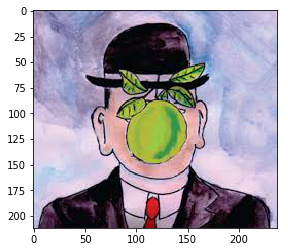

In [5]:
plt.gray()
plt.imshow(img)
plt.show()

In [6]:
def array_to_bytes(arr):
    import zlib
    arr_shape = arr.shape
    arr_bytes = np.dot(arr.flatten(order='C'), 1).astype(np.uint8)
    print(len(arr.flatten().astype(np.uint8)))
    # return arr_bytes
    return arr_shape, zlib.compress(arr_bytes)

In [7]:
img_shape, image_compressed = array_to_bytes(img)
print(img_shape)
print(len(image_compressed))

151368
(212, 238, 3)
118835


In [8]:
type(image_compressed)

bytes

In [9]:
with tf.python_io.TFRecordWriter('test_p2g.tfrecord') as p2g_writer:

    # Serialize to string and write to file
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'filename': _bytes_feature(bytes('test', 'utf-8')),

                'heatmaps': _bytes_feature(image_compressed),
                'heatmaps/height': _int64_feature(img_shape[0]),
                'heatmaps/width': _int64_feature(img_shape[1]),
                'heatmaps/depth': _int64_feature(img_shape[2]),

                'rdm': _bytes_feature(image_compressed),
                'rdm/height': _int64_feature(img_shape[0]),
                'rdm/width': _int64_feature(img_shape[1]), 
                'rdm/depth': _int64_feature(img_shape[2]),

                'raw': _bytes_feature(image_compressed),
                'raw/height': _int64_feature(img_shape[0]),
                'raw/width': _int64_feature(img_shape[1]),
                'raw/depth': _int64_feature(img_shape[2]),
            }
                                  )
                              )
    
    p2g_writer.write(example.SerializeToString())

### Testwise desiralization

In [10]:
file = "test_p2g.tfrecord"
test_dataset = tf.data.TFRecordDataset('test_p2g.tfrecord')


In [11]:
def _parse_p2g_example(serialized_example):
    
    p2g_feature = {
        'filename': tf.FixedLenFeature([],tf.string),

        'heatmaps': tf.FixedLenFeature([],tf.string),
        'heatmaps/height': tf.FixedLenFeature([], tf.int64),
        'heatmaps/width': tf.FixedLenFeature([],tf.int64),
        'heatmaps/depth': tf.FixedLenFeature([], tf.int64),

        'rdm': tf.FixedLenFeature([],tf.string),
        'rdm/height': tf.FixedLenFeature([], tf.int64), 
        'rdm/width': tf.FixedLenFeature([],tf.int64), 
        'rdm/depth': tf.FixedLenFeature([], tf.int64),

        'raw': tf.FixedLenFeature([],tf.string),
        'raw/height': tf.FixedLenFeature([], tf.int64),  
        'raw/width': tf.FixedLenFeature([],tf.int64), 
        'raw/depth': tf.FixedLenFeature([], tf.int64), 

    }  
    
    return tf.parse_single_example(serialized_example, p2g_feature)

In [12]:
def get_data(example):
    filename = tf.cast(example['filename'], tf.string)

    # Heatmap
    height = example['heatmaps/height'].numpy()
    width = example['heatmaps/width'].numpy()
    depth = example['heatmaps/depth'].numpy()
    
    heatmap_str = tf.io.decode_compressed(example['heatmaps'], compression_type='ZLIB')
    heatmap_flat = tf.decode_raw(heatmap_str, out_type=tf.uint8)
    heatmap = tf.reshape(heatmap_flat, tf.stack([height, width, depth]))
    
    # Range-doppler maps
    height = example['rdm/height'].numpy()
    width = example['rdm/width'].numpy()
    depth = example['rdm/depth'].numpy()
    
    rdm_str = tf.io.decode_compressed(example['rdm'], compression_type='ZLIB')
    rdm_flat = tf.decode_raw(rdm_str, out_type=tf.uint8)
    rdm = tf.reshape(rdm_flat, tf.stack([height, width, depth]))
    
    # Raw samples
    height = example['raw/height'].numpy()
    width = example['raw/width'].numpy()
    depth = example['raw/depth'].numpy()
    
    raw_str = tf.io.decode_compressed(example['raw'], compression_type='ZLIB')
    raw_flat = tf.decode_raw(raw_str, out_type=tf.uint8)
    raw = tf.reshape(raw_flat, tf.stack([height, width, depth]))
                         
    return heatmap.numpy(), rdm.numpy(), raw.numpy()

In [13]:
parsed_test_dataset = test_dataset.map(_parse_p2g_example)


Instructions for updating:
Colocations handled automatically by placer.


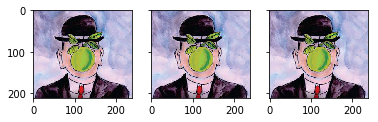

In [14]:
for example in parsed_test_dataset:
        
    heatmap, rdm, raw = get_data(example)
    
    f, ax = plt.subplots(1, 3, sharey=True) 
    ax[0].imshow(heatmap)
    ax[1].imshow(rdm)
    ax[2].imshow(raw)

    plt.show()
    # Exit after 1 iteration as this is purely demonstrative.
    break
